In [1]:
from padre_meddea.io.file_tools import read_file
from pathlib import Path
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from padre_meddea.util import util as util
from astropy.time import Time

from specutils import SpectralRegion
from specutils.manipulation import extract_region
from astropy.visualization import quantity_support
from astropy.modeling import models
from specutils.fitting import fit_lines

quantity_support()
import specutils
import matplotlib.pyplot as plt
specutils.conf.do_continuum_function_check = False
%load_ext autoreload
%autoreload 2

import padre_meddea
import padre_meddea.spectrum.calibration as cal

from padre_meddea.util.util import PixelList

c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
padre_meddea.__version__

'0.1.dev67+g422145b'

In [3]:
str(Time.now())

'2025-07-15 12:54:44.432972'

This notebook demonstrates the fast energy calibration tools that are provided in padre_meddea for event list (or photon data). This calibration is specific to a Ba-133 spectrum which is the calibration source on board Meddea.  The main calibration function is cal.The calibration steps are
* determine a rough calibration function by finding the two strongest lines (cal.get_calfunc_barium_rough)
* estimate the location of the rest of the barium lines and fit the precise location of peaks of those lines (cal.fit_peaks)
* determine the linear transformation between adc channel and energy

The primary function which performs all of these steps is cal.calibrate_phlist_barium_linear.
This function returns an array of linear parameters for all pixels.
This array can then be passed into the PhotonList object to create add a new column to the event_list data for the energy of the event.

In [4]:
ba_ph_file = Path("padre_meddea_l0test_photon_20250130T104655_v0.1.0.fits")
ba_spec_file = Path("padre_meddea_l0test_spectrum_20250130T104648_v0.1.0.fits")
am_ph_file = Path("padre_meddea_l0test_photon_20250130T121755_v0.1.0.fits")
am_spec_file = Path("padre_meddea_l0test_spectrum_20250130T121750_v0.1.0.fits")
ba_hk_file = Path("padre_meddea_l0test_housekeeping_20250130T104656_v0.1.0.fits")
am_hk_file = Path("padre_meddea_l0test_housekeeping_20250130T121800_v0.1.0.fits")

# Barium-133 Photon Data

In [5]:
ph_list = read_file(ba_ph_file)

In [6]:
ph_list

PhotonList (7,048,844 events)
2025-01-30 10:46:55.257 - 11:59:56.462 (1hr 13min 1.205s)
{'event_list': <TimeSeries length=7048844>
          time          seqcount clocks  asic ...  pkttimes pktclock pixel
          Time           uint16  uint16 uint8 ...   uint32   uint32  int64
----------------------- -------- ------ ----- ... --------- -------- -----
2025-01-30 10:46:55.257      812      0     0 ... 791549220  5144806     0
2025-01-30 10:46:55.258      812     59     2 ... 791549220  5144806     0
2025-01-30 10:46:55.259      812    138     1 ... 791549220  5144806     4
2025-01-30 10:46:55.259      812    176     0 ... 791549220  5144806     4
2025-01-30 10:46:55.260      812    207     0 ... 791549220  5144806     6
2025-01-30 10:46:55.260      812    211     3 ... 791549220  5144806     6
2025-01-30 10:46:55.261      812    316     3 ... 791549220  5144806     0
2025-01-30 10:46:55.262      812    336     3 ... 791549220  5144806     0
2025-01-30 10:46:55.262      812    407     

In [7]:
ph_list.pkt_list

time,seqcount,pkttimes,pktclock,livetime,inttime,flags,decim_lvl,drop_cnt,int_time_flag,num_hits,rate,corr_rate
Time,uint16,uint32,uint32,uint16,uint16,uint16,uint16,uint16,uint16,uint32,float64,float64
2025-01-30 10:46:55.257,812,791549220,5144806,6519,7210,45200,3,144,32768,143,1549.4972260748962,1713.740604387176
2025-01-30 10:46:55.350,813,791549220,6990913,6032,6721,45198,3,142,32768,143,1662.2340425531913,1852.1012931034481
2025-01-30 10:46:55.436,814,791549220,8729302,6818,7504,45200,3,144,32768,143,1488.789312366738,1638.5853622763275
2025-01-30 10:46:55.532,815,791549220,10634156,6309,6992,45199,3,143,32768,143,1597.808209382151,1770.7838009193217
2025-01-30 10:46:55.621,816,791549220,12427437,5631,6311,45198,3,142,32768,143,1770.2226271589288,1983.9948499378443
2025-01-30 10:46:55.703,817,791549220,14063183,6729,7426,45200,3,144,32768,144,1514.9474818206304,1671.8680338831923
2025-01-30 10:46:55.797,818,791549220,15935995,5552,6254,45200,3,144,32768,143,1786.3567316917172,2012.225324207493
2025-01-30 10:46:55.877,819,791549220,17544407,6363,7053,45199,3,143,32768,143,1583.9890826598612,1755.7559327361307
2025-01-30 10:46:55.967,820,791549220,19347443,6634,7329,45198,3,142,32768,143,1524.338245326784,1684.0330117576125


In [8]:
ph_list.event_list

time,seqcount,clocks,asic,channel,atod,baseline,pkttimes,pktclock,pixel
Time,uint16,uint16,uint8,uint8,uint16,uint16,uint32,uint32,int64
2025-01-30 10:46:55.257,812,0,0,26,1115,3555,791549220,5144806,0
2025-01-30 10:46:55.258,812,59,2,26,1305,3581,791549220,5144806,0
2025-01-30 10:46:55.259,812,138,1,29,1179,3541,791549220,5144806,4
2025-01-30 10:46:55.259,812,176,0,29,1145,3556,791549220,5144806,4
2025-01-30 10:46:55.260,812,207,0,5,1817,3534,791549220,5144806,6
2025-01-30 10:46:55.260,812,211,3,5,472,3472,791549220,5144806,6
2025-01-30 10:46:55.261,812,316,3,26,1247,3553,791549220,5144806,0
2025-01-30 10:46:55.262,812,336,3,26,1143,3498,791549220,5144806,0
2025-01-30 10:46:55.262,812,407,2,0,1131,3578,791549220,5144806,7


In [9]:
hk_ts, cmd_ts = read_file(ba_hk_file)

In [10]:
hk_ts

time,timestamp,fp_temp,dib_temp,hvps_temp,hvps_vsense,hvps_csense,csense_15v,csense_33vd,csense_33va,hit_rate,good_cmd_cnt,error_cnt,heater_pwm_duty_cycle,decimation_rate,error_summary,seqcount
Time,uint32,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16,uint16
2025-01-30 10:46:56.000,791549221,35488,28704,17963,29735,7287,28328,35073,36209,3181,979,0,2151,65325,111,1651
2025-01-30 10:47:01.000,791549226,35488,28704,17956,29732,6885,28314,35072,36229,3258,979,0,2151,65325,111,1652
2025-01-30 10:47:06.000,791549231,35488,28701,17942,29731,7001,28310,34906,36201,3103,979,0,2151,65325,111,1653
2025-01-30 10:47:11.000,791549236,35488,28699,17939,29732,7169,28159,35012,36233,3134,979,0,2151,65325,111,1654
2025-01-30 10:47:16.000,791549241,35488,28694,17934,29735,6867,28316,34902,36228,3307,979,0,2151,65325,111,1655
2025-01-30 10:47:21.000,791549246,35488,28693,17931,29733,6836,28309,34998,36232,3271,979,0,2151,65325,111,1656
2025-01-30 10:47:26.000,791549251,35488,28689,17918,29737,6945,28313,35086,36223,3166,979,0,2151,65325,111,1657
2025-01-30 10:47:31.000,791549256,35488,28688,17911,29735,6739,28308,34897,36233,3176,979,0,2151,65325,111,1658
2025-01-30 10:47:36.000,791549261,35488,28688,17909,29734,6727,28307,34993,36211,3198,979,0,2151,65325,111,1659


In [11]:
cmd_ts

time,pkttimes,pktclock,address,value,seqcount,name
Time,uint32,uint32,uint16,uint16,uint16,bytes17
2025-01-30 10:46:55.418,791549220,8357103,0,17,363,mode
2025-01-30 10:46:55.419,791549220,8389995,1280,22993,364,commit_hash_least
2025-01-30 10:46:55.421,791549220,8424615,1282,2011,365,commit_hash_most
2025-01-30 10:46:55.423,791549220,8459235,1284,36929,366,user_hash_least
2025-01-30 10:46:55.425,791549220,8493855,1286,8984,367,user_hash_most
2025-01-30 10:46:55.426,791549220,8528475,1288,40989,368,build_time_least
2025-01-30 10:46:55.428,791549220,8563095,1290,26522,369,build_time_most


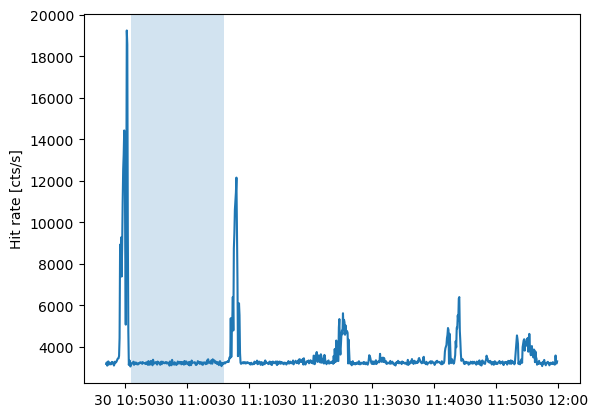

In [12]:
plt.plot(hk_ts.time.to_datetime(), hk_ts['hit_rate'])
plt.ylabel("Hit rate [cts/s]")
good_tr = [Time('2025-01-30T10:51'), Time('2025-01-30T11:06')]
plt.axvspan(good_tr[0].to_datetime(), good_tr[1].to_datetime(), alpha=0.2)

Times with increased hit rate is due to microphonics from the cooling system. The following calibration could be improved by including more data.

In [13]:
good_tr

[<Time object: scale='utc' format='isot' value=2025-01-30T10:51:00.000>,
 <Time object: scale='utc' format='isot' value=2025-01-30T11:06:00.000>]

In [14]:
ph_list = ph_list[good_tr[0]:good_tr[1]]

In [15]:
ph_list

PhotonList (1,437,017 events)
2025-01-30 10:51:00.001 - 11:06:00.000 (14min 59.999s)
{'event_list': <TimeSeries length=1437017>
          time          seqcount clocks  asic ...  pkttimes pktclock pixel
          Time           uint16  uint16 uint8 ...   uint32   uint32  int64
----------------------- -------- ------ ----- ... --------- -------- -----
2025-01-30 10:51:00.001     3816   6091     1 ... 791549464 18451425     0
2025-01-30 10:51:00.001     3816   6119     3 ... 791549464 18451425     1
2025-01-30 10:51:00.001     3816   6138     2 ... 791549464 18451425     3
2025-01-30 10:51:00.004     3816   6379     0 ... 791549464 18451425     0
2025-01-30 10:51:00.005     3816   6403     3 ... 791549464 18451425     1
2025-01-30 10:51:00.005     3816   6468     0 ... 791549464 18451425     6
2025-01-30 10:51:00.005     3816   6473     2 ... 791549464 18451425     6
2025-01-30 10:51:00.006     3816   6503     1 ... 791549464 18451425     5
2025-01-30 10:51:00.006     3816   6541     3 .

In [ ]:
all_pixel_list = PixelList().all()
all_pixel_list

Text(0.5, 1.0, 'All pixels')

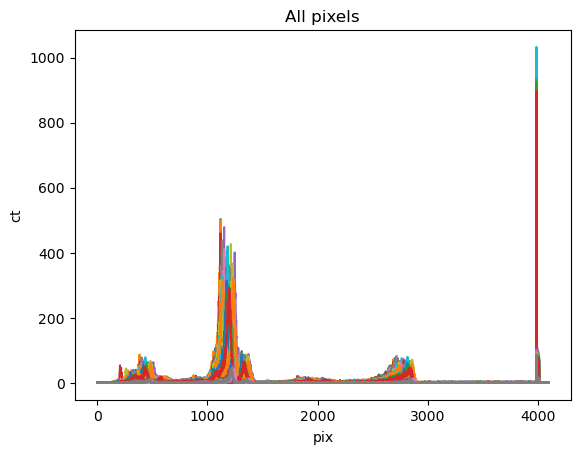

In [21]:
fig, ax = plt.subplots()
for this_pixel in all_pixel_list:
    this_spec = ph_list.spectrum(pixel_list=this_pixel)
    ax.plot(this_spec.spectral_axis, this_spec.flux)
plt.title("All pixels")

Text(0.5, 1.0, "['Det0Pixel0L']")

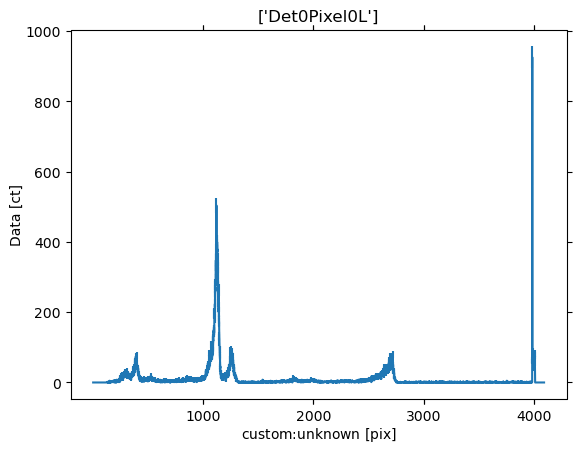

In [23]:
select_pixel = PixelList(asics=[0], pixels=[0])
ph_list.spectrum(pixel_list=select_pixel).plot()
plt.title(f"{select_pixel['label'].value}")

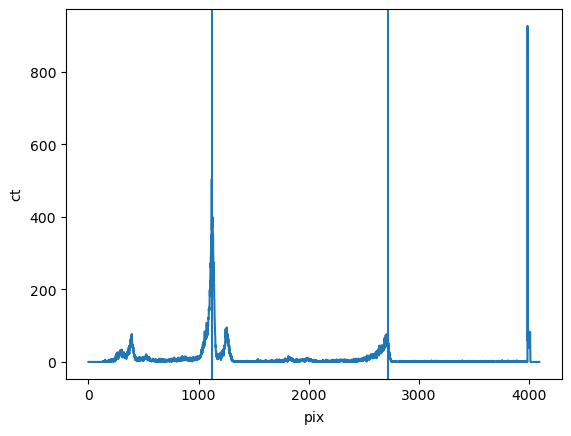

In [25]:
select_pixel = PixelList(asics=[0], pixels=[0])
this_spec = ph_list.spectrum(pixel_list=select_pixel)
f = cal.get_calfunc_barium_rough(this_spec, plot=True)


In [28]:
#lin_cal_params = cal.calibrate_phlist_barium_linear(ph_list, plot=True)  # outputs 2 plots per pixel
lin_cal_params = cal.calibrate_phlist_barium_linear(ph_list)


In [29]:
lin_cal_params.shape

(4, 12, 2)

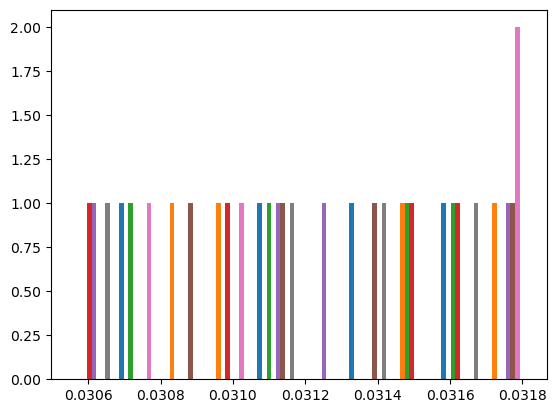

In [30]:
plt.hist(lin_cal_params[:, 0:8, 0]);


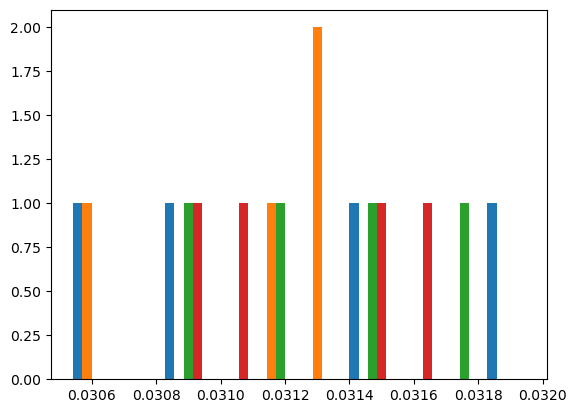

In [31]:
plt.hist(lin_cal_params[:, 8:, 0]);


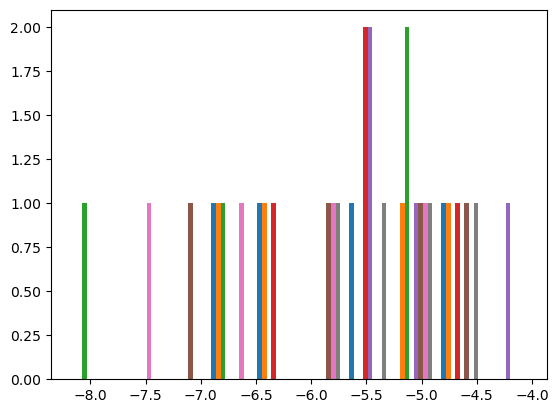

In [32]:
plt.hist(lin_cal_params[:, 0:8, 1]);


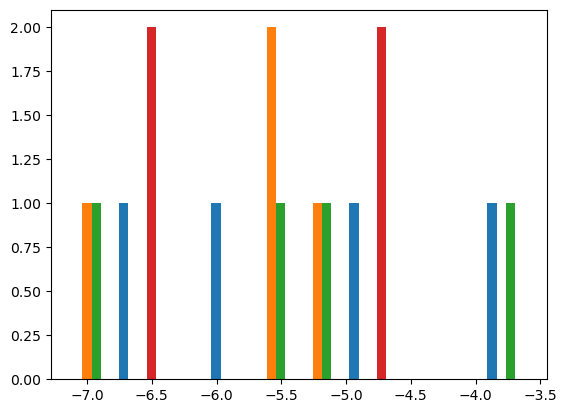

In [33]:
plt.hist(lin_cal_params[:, 8:, 1]);


In [34]:
cal_ph_list = cal.calibrate_linear_phlist(ph_list, lin_cal_params)

<WCSAxes: ylabel='Data [ct]'>

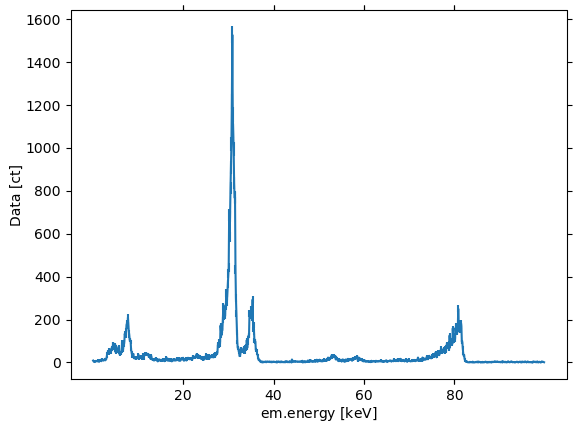

In [36]:
select_pixel = PixelList(asics=[0], pixels=[0])
cal_ph_list.spectrum(pixel_list=select_pixel, calibrate=True).plot()

Text(0.5, 1.0, 'All large pixels')

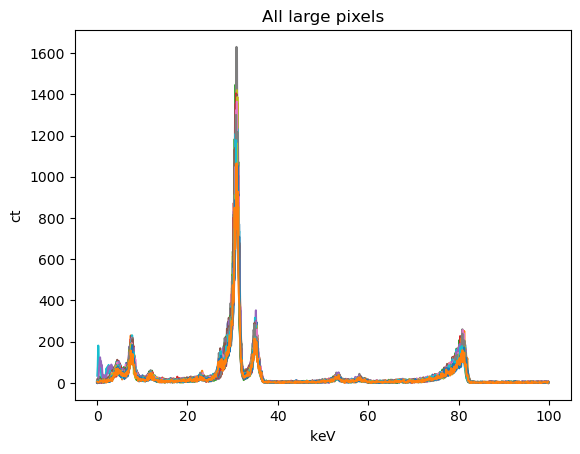

In [41]:
fig, ax = plt.subplots()
for this_pixel in all_pixel_list.select_large():
    this_spec = ph_list.spectrum(pixel_list=this_pixel, calibrate=True)
    ax.plot(this_spec.spectral_axis, this_spec.flux)
plt.title("All large pixels")

Text(0.5, 1.0, 'All small pixels')

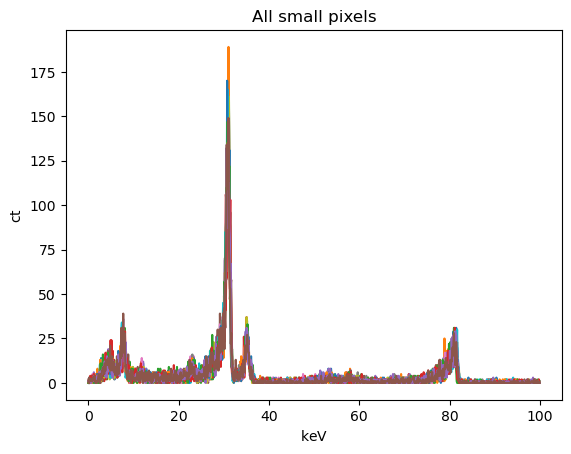

In [42]:
fig, ax = plt.subplots()
for this_pixel in all_pixel_list.select_small():
    this_spec = ph_list.spectrum(pixel_list=this_pixel, calibrate=True)
    ax.plot(this_spec.spectral_axis, this_spec.flux)
plt.title("All small pixels")

In [44]:
ba_line_energies = [7.8, 11.8, 30.85, 35, 53.5, 57.8, 81] * u.keV

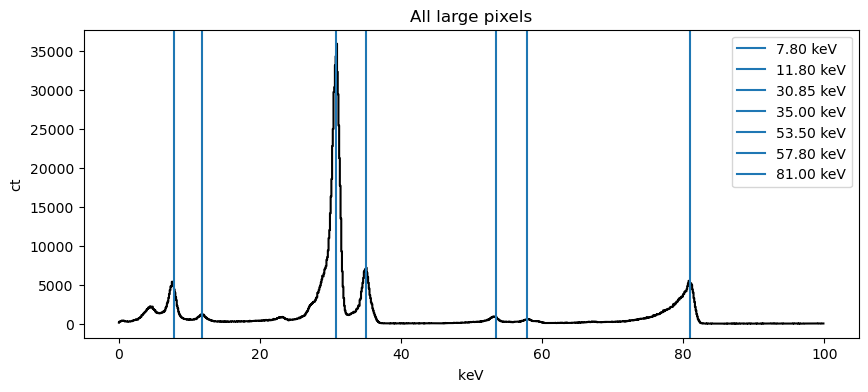

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
large_pix_spec = ph_list.spectrum(pixel_list=all_pixel_list.select_large(), calibrate=True)
ax.step(large_pix_spec.spectral_axis, large_pix_spec.flux, color='black')
plt.title("All large pixels")
for this_energy in ba_line_energies:
    ax.axvline(this_energy, label=f"{this_energy:0.2f}")
plt.legend()

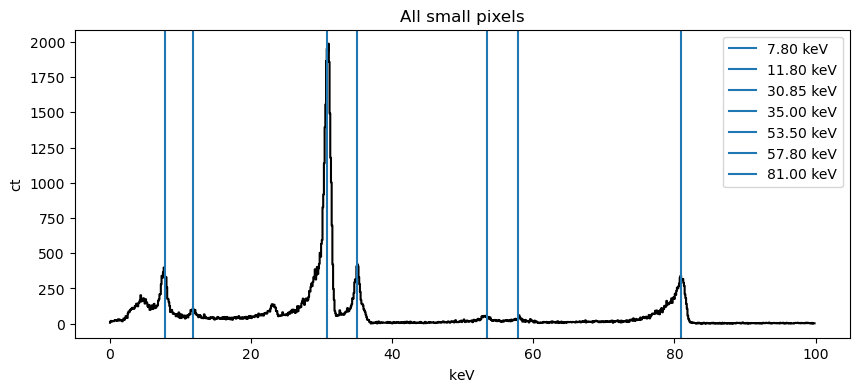

In [67]:
fig, ax = plt.subplots(figsize=(10, 4))
small_pix_spec = ph_list.spectrum(pixel_list=all_pixel_list.select_small(), calibrate=True)
ax.step(small_pix_spec.spectral_axis, small_pix_spec.flux, color='black')
plt.title("All small pixels")
for this_energy in ba_line_energies:
    ax.axvline(this_energy, label=f"{this_energy:0.2f}")
plt.legend()

## Low energy threshold requirement

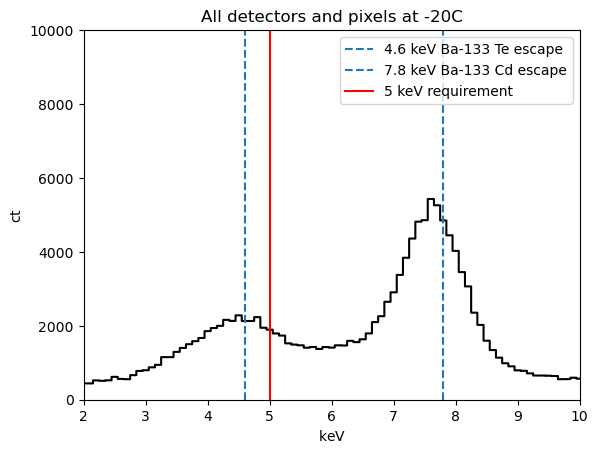

In [51]:
fig, ax = plt.subplots()
ax.step(large_pix_spec.spectral_axis, large_pix_spec.flux, color="black")
plt.axvline(4.6 * u.keV, label="4.6 keV Ba-133 Te escape", linestyle='dashed')
plt.axvline(7.8 * u.keV, label="7.8 keV Ba-133 Cd escape", linestyle='dashed')
plt.axvline(5, label='5 keV requirement', color='red')
plt.xlim(2, 10)
plt.ylim(0, 10000)
plt.title("All detectors and pixels at -20C")
plt.legend()

## High energy threshold

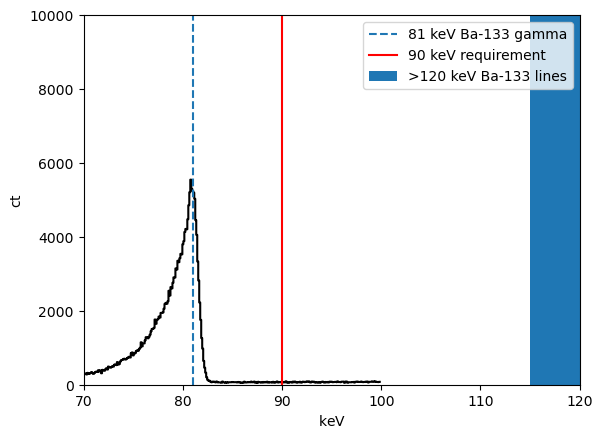

In [53]:
energy_bins = np.arange(0, 120, 0.1)
fig, ax = plt.subplots()
ax.step(large_pix_spec.spectral_axis, large_pix_spec.flux, color="black")
ax.axvline(ba_line_energies[-1], label="81 keV Ba-133 gamma", linestyle='dashed')
ax.axvline(90 * u.keV, label='90 keV requirement', color='red')
ax.axvspan(115 * u.keV, 120 * u.keV, label='>120 keV Ba-133 lines')
plt.xlim(70, 120)
plt.ylim(0, 10000)
plt.legend()

In [54]:
from astropy.modeling import models, fitting
from specutils.analysis import fwhm
from specutils.fitting import estimate_line_parameters


In [55]:
def plot_fwhm(spec, line_energy):
    line_region = SpectralRegion(line_energy - 2 * u.keV, line_energy + 2 * u.keV)
    sub_spec = extract_region(spec, line_region)
    result = estimate_line_parameters(sub_spec, models.Gaussian1D())
    g_init = models.Gaussian1D(
        amplitude=result.amplitude, mean=result.mean, stddev=result.stddev
    )
    g_fit = fit_lines(sub_spec, g_init)
    x = sub_spec.spectral_axis
    plt.step(x, sub_spec.flux, color="black")
    plt.plot(x, g_fit(x), label=f"gauss fwhm {g_fit.fwhm:0.2f}")
    # fit = fitting.LMLSQFitter()
    # bigauss = BiGaussian1D(amplitude=result.amplitude.value, mean=result.mean.value, stddev1=result.stddev.value, stddev2=result.stddev.value * 0.5)
    # fitted_line = fit(bigauss, x.value, sub_spec.flux.value, maxiter=2000)
    # plt.plot(x, fitted_line(x.value))
    spec_fwhm = fwhm(sub_spec)
    max_ind = np.argmax(sub_spec.flux)
    left = x[max_ind] - spec_fwhm / 2.0
    right = x[max_ind] + spec_fwhm / 2.0
    plt.axvline(x[max_ind])
    plt.axvspan(left, right, alpha=0.2, label=f"{spec_fwhm:0.2f}")
    plt.legend()

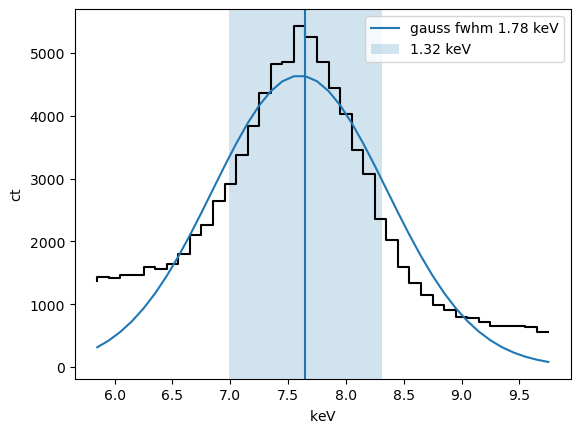

In [68]:
plot_fwhm(large_pix_spec, ba_line_energies[0])

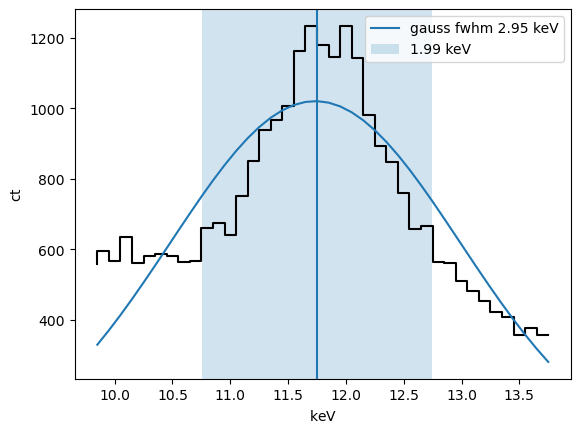

In [69]:
plot_fwhm(large_pix_spec, ba_line_energies[1])

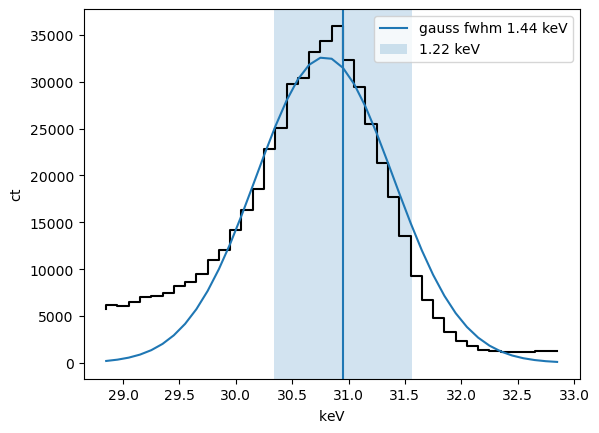

In [70]:
plot_fwhm(large_pix_spec, ba_line_energies[2])

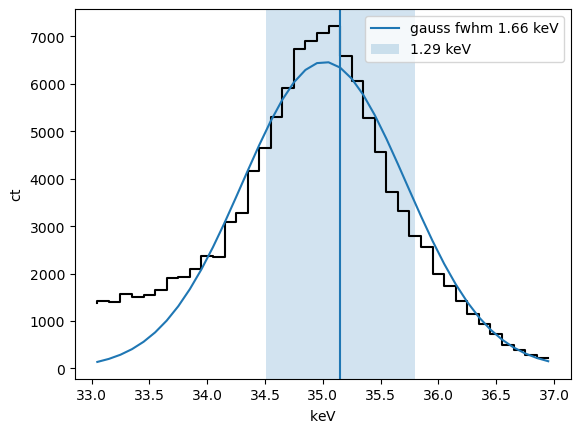

In [71]:
plot_fwhm(large_pix_spec, ba_line_energies[3])


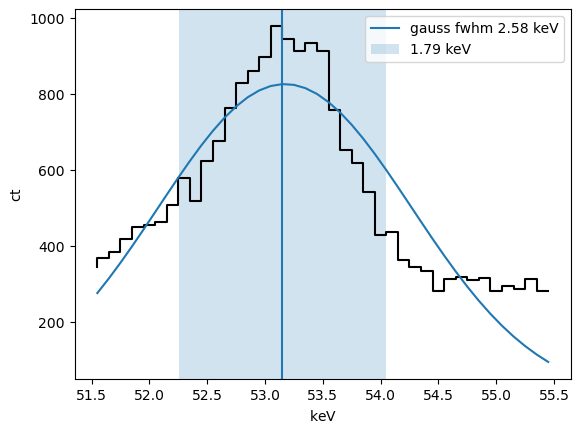

In [72]:
plot_fwhm(large_pix_spec, ba_line_energies[4])


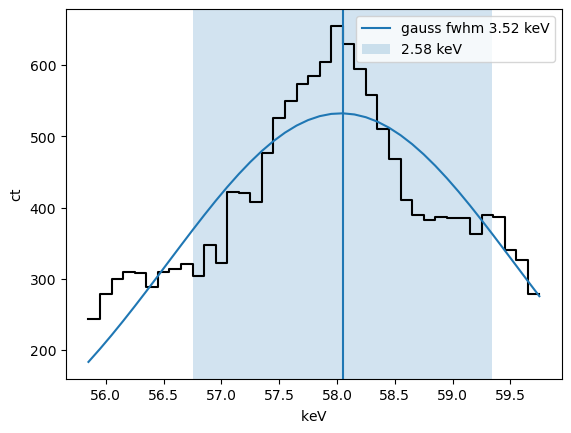

In [73]:
plot_fwhm(large_pix_spec, ba_line_energies[5])


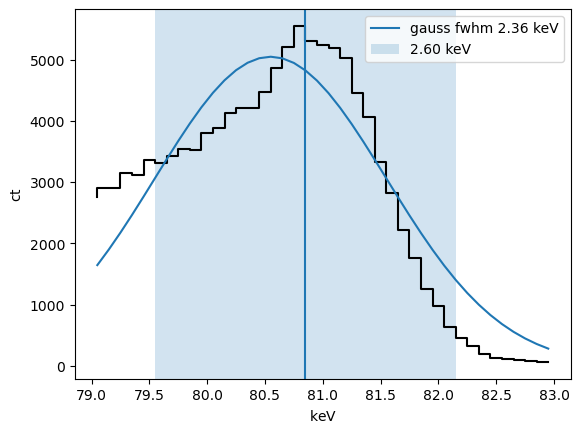

In [74]:
plot_fwhm(large_pix_spec, ba_line_energies[6])


Does not work well due to significant tailing at this energy.

## Americium data

In [59]:
am_lines = [13.9, 17.8, 20.8, 26.4, 59.5] * u.keV

In [60]:
am_ph_list = read_file(am_ph_file)

In [61]:
cal_am_ph_list = cal.calibrate_linear_phlist(am_ph_list, lin_cal_params)

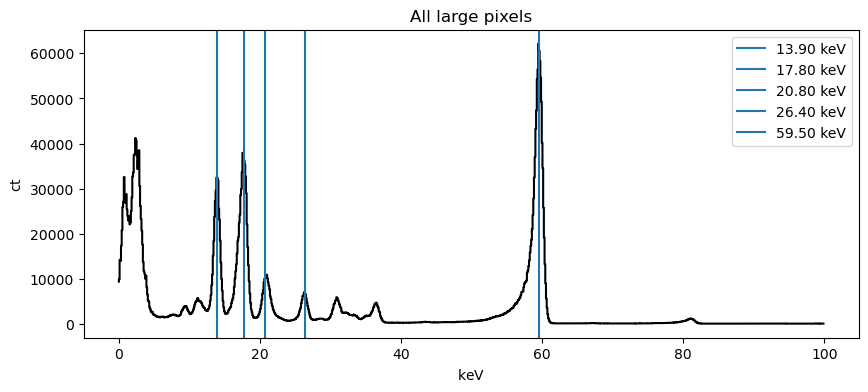

In [75]:
fig, ax = plt.subplots(figsize=(10, 4))
large_pix_am_spec = cal_am_ph_list.spectrum(pixel_list=all_pixel_list.select_large(), calibrate=True)
ax.step(large_pix_am_spec.spectral_axis, large_pix_am_spec.flux, color='black')
plt.title("All large pixels")
for this_energy in am_lines:
    ax.axvline(this_energy, label=f"{this_energy:0.2f}")
plt.legend()


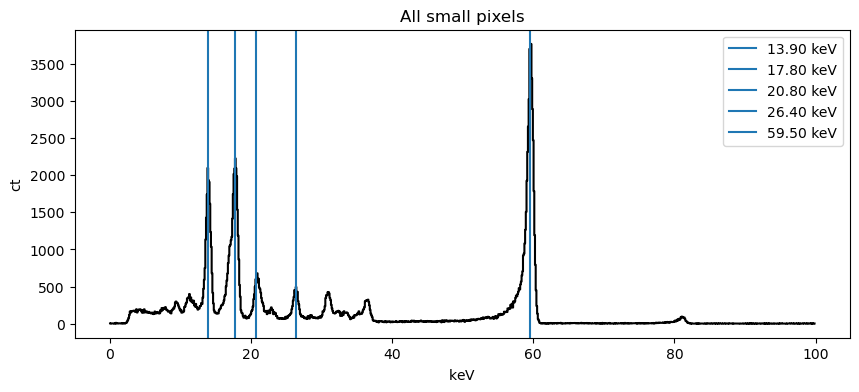

In [76]:
fig, ax = plt.subplots(figsize=(10, 4))
small_pix_am_spec = cal_am_ph_list.spectrum(pixel_list=all_pixel_list.select_small(), calibrate=True)
ax.step(small_pix_am_spec.spectral_axis, small_pix_am_spec.flux, color='black')
plt.title("All small pixels")
for this_energy in am_lines:
    ax.axvline(this_energy, label=f"{this_energy:0.2f}")
plt.legend()

